# LSTM 

In [1]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import xarray as xr
from itertools import product
from tqdm.auto import tqdm

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from lstm import WindowedTimeSeries, train_model, predict_one_step, predict_autoregressive, evaluate_model

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
series = generate_data(10000, noise_level=0.05)
train_series = series[:8000, :]
val_series = series[8000:9000, :]
test_series = series[9000:, :]
train_series.shape

(8000, 3)

In [4]:
train_dataset = WindowedTimeSeries(train_series, seq_length=10)
val_dataset = WindowedTimeSeries(val_series, seq_length=10)
test_dataset = WindowedTimeSeries(test_series, seq_length=10)

In [5]:
model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=100,
  patience=10,
  device=device)

Epoch [10/100], train_loss: 1.1198, val_loss: 1.0353
Epoch [20/100], train_loss: 1.0971, val_loss: 1.1401
Early stopping triggered at epoch: 23


In [6]:
evaluate_model(model, test_dataset)

1.0511404275894165

## LSTM Using Direct Predictions

In [10]:
train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=20)
val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=20)
test_dataset = WindowedTimeSeries(test_series, seq_length=10, horizon=20)

In [8]:
model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=100,
  patience=100)

Epoch [10/100], train_loss: 41.9599, val_loss: 42.8411
Epoch [20/100], train_loss: 30.5282, val_loss: 36.5747
Epoch [30/100], train_loss: 27.3466, val_loss: 34.0140
Epoch [40/100], train_loss: 26.6906, val_loss: 34.0148
Epoch [50/100], train_loss: 26.0829, val_loss: 30.8168
Epoch [60/100], train_loss: 24.4588, val_loss: 29.7153
Epoch [70/100], train_loss: 23.9919, val_loss: 30.8509
Epoch [80/100], train_loss: 23.7854, val_loss: 28.2305
Epoch [90/100], train_loss: 21.1680, val_loss: 27.1534
Epoch [100/100], train_loss: 21.1283, val_loss: 26.2891


In [15]:
evaluate_model(model, test_dataset)

16.797386169433594

In [11]:
# steps = [1,5,10,15,20]
steps = np.arange(1,21)
MSE = np.zeros((len(steps)))

for i, step in enumerate(steps):
  train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=step)
  val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=step)
  test_dataset = WindowedTimeSeries(test_series, seq_length=10, horizon=step)  

  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=100,
  patience=20,
  silence=True,
  device=torch.device("mps"))

  mse = evaluate_model(model, test_dataset)
  MSE[i] = mse
  print(f"{step} Steps, MSE: {mse}")

1 Steps, MSE: 1.040200114250183
2 Steps, MSE: 1.0210812091827393
3 Steps, MSE: 1.147091031074524
4 Steps, MSE: 1.2432961463928223
5 Steps, MSE: 1.6597900390625
6 Steps, MSE: 2.416893482208252
7 Steps, MSE: 3.913623332977295
8 Steps, MSE: 4.771604537963867
9 Steps, MSE: 6.763916969299316
10 Steps, MSE: 9.7144193649292
11 Steps, MSE: 11.7783784866333
12 Steps, MSE: 10.138693809509277
13 Steps, MSE: 10.14110279083252
14 Steps, MSE: 8.51712703704834
15 Steps, MSE: 9.297037124633789
16 Steps, MSE: 8.979769706726074
17 Steps, MSE: 12.124516487121582
18 Steps, MSE: 12.036664962768555
19 Steps, MSE: 12.70776653289795
20 Steps, MSE: 15.915252685546875


In [12]:
ds = xr.Dataset(
  data_vars=dict(
    mse=(["k"], MSE),
  ),
  coords=dict(
    k=steps,
  ),
  attrs=dict(
    epochs=100,
    patience=20,
  )
)

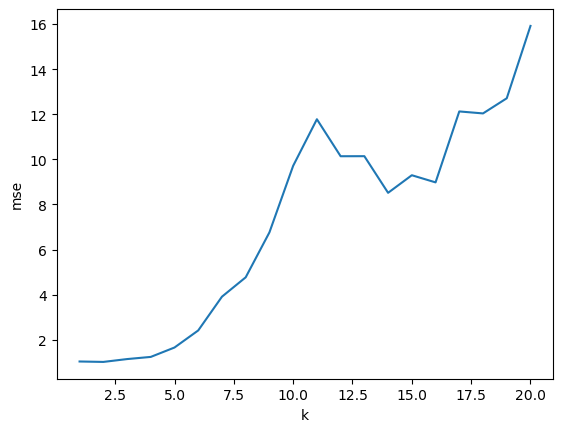

In [13]:
ds.mse.plot(x="k")


In [14]:
out_path = Path("../data/processed/mse_LSTM2.nc")

ds.to_netcdf(out_path)

# Training LSTMs with different hidden sizes

In [42]:
hidden_sizes = np.arange(2,42,2)
k_range = [5,10,15]
configs = list(product(hidden_sizes, k_range))

In [30]:
mse = xr.DataArray(
    np.full(
        (len(hidden_sizes), len(k_range)),
        np.nan,
    ),
    dims=("hidden_size", "k"),
    coords={
        "hidden_size": hidden_sizes,
        "k": k_range,},
    name="mse",
)

In [41]:
ds = xr.Dataset(
    {
        "mse": (("k", "hidden_size"),
                np.full((len(k_range), len(hidden_sizes)), np.nan))
    },
    coords={
        "k": k_range,
        "data_size": hidden_sizes
    }
)

In [ ]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")

for h, k in pbar:
  train_dataset = WindowedTimeSeries(train_series, seq_length=10, horizon=k)
  val_dataset = WindowedTimeSeries(val_series, seq_length=10, horizon=k) 
  test_dataset = WindowedTimeSeries(test_series, seq_length=10, horizon=k)

  device = torch.device("mps") if h >= 25 else torch.device("cpu")
 
  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=int(h),
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=100,
  patience=100,
  silence=True,
  device=device)

  mse = evaluate_model(model, test_dataset)

  ds["mse"].loc[dict(hidden_size=h,k=k)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", h=h, k=k)

In [ ]:
ds["mse"].sel(k=5).plot()

In [ ]:
out_path = Path("../data/processed/mse_LSTM_h-range.nc")
ds.attrs["patience"] = 100

ds.to_netcdf(out_path)

# LSTM Over range of data sizes

In [9]:
k_range = [5,10,15]
data_size_range = np.arange(100,2001,100)
configs = list(product(k_range, data_size_range))

In [10]:
ds = xr.Dataset(
    {
        "mse": (("k", "data_size"),
                np.full((len(k_range), len(data_size_range)), np.nan))
    },
    coords={
        "k": k_range,
        "data_size": data_size_range
    }
)

In [ ]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")

for k, size in pbar:
  train_series_short = train_series[1000:1000+size,]
  val_series_new = series[4000:5000, :]
  test_series_new = series[5000:, :]

  train_dataset = WindowedTimeSeries(train_series_short, seq_length=10, horizon=k)
  val_dataset = WindowedTimeSeries(val_series_new, seq_length=10, horizon=k) 
  test_dataset = WindowedTimeSeries(test_series_new, seq_length=10, horizon=k)

  model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=300,
  silence=True,
  patience=3w00,
  device=torch.device("mps"))

  mse = evaluate_model(model, test_dataset)

  ds["mse"].loc[dict(data_size=size,k=k)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", size=size, k=k)
  

Hyperparameter Sweep:   0%|          | 0/60 [00:00<?, ?it/s]

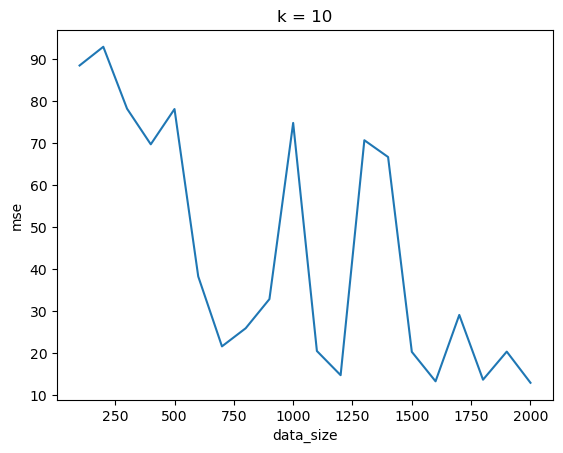

In [16]:
ds["mse"].sel(k=10).plot()

In [ ]:
out_path = Path("../data/processed/mse_LSTM_d-range.nc")

ds.attrs["patience"] = 100
ds.attrs["epochs"] = 300
ds.attrs["test_size"] = 5000

ds.to_netcdf(out_path)